[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/qutip/qutip-tensorflow/blob/main/examples/rotation_optimization.ipynb)

# Learning a unitary using qutip-tensorflow

In this notebook we will demonstrate the use of qutip-tensorflow to optimize
the parameters of a unitary gate using gradient descent. We will optimize a
parametrized unitary operation in a two level system, a qubit. The unitary
operation will consist on three consecutive rotations in the Z-Y-Z axis
respectively. This unitary realizes the most general operation that one can
achieve on a qubit and it can be expressed as
$$
U(\alpha, \beta, \gamma) = \exp(-i \alpha/2 \sigma_z)\cdot\exp(-i \beta/2 \sigma_y)\cdot\exp(-i \gamma/2 \sigma_z).
$$
where $\sigma_{x, y, z}$ are the Pauli matrices.

Our goal is to optimize the parameters $\alpha, \beta$ and $\gamma$ to fully
rotate a qubit that starts in the state $|\uparrow\rangle$ ($|0\rangle$) such
that the final state is $|\downarrow>$ ($|1\rangle$).

We will use TensorFlow to compute the gradients of a loss function that we
define as the overlap between the target state and the initial state on which
we apply our unitary:


$$
\text{loss}(\alpha, \beta, \gamma) = -|\langle 0| U(\alpha, \beta, \gamma) |1 \rangle|
$$

Note that we need to install the dev major version of `qutip` and `qutip-tensorflow`
for this notebook to work.

In [1]:
# Installations. This is only necessary when using colab. 
# If running locally install the packages manually as explained in
# the main page of the repository.


# !pip install git+https://github.com/qutip/qutip.git@dev.major
# !pip install git+https://github.com/qutip/qutip-tensorflow.git

In [2]:
# imports
import numpy as np

import qutip
import tensorflow as tf

# By importing qutip_tensorflow we "patch" qutip to include a new data backed 
# that is based on tensorflows Tensor object.
import qutip_tensorflow as qtf

# Tensorflow does not perform automatic casting of types, which means 
# tf.constant(1)*tf.constant(1.) raises error due to being different 
# types (int32 and float 32 respectively). 
# We recommend enabling experimental_numpy_behavior so that automatic 
# casting gets enabled.
import tensorflow.experimental.numpy as tnp
tnp.experimental_enable_numpy_behavior()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

2021-10-05 18:44:48.637726: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Autodifferentiation

Before reading this Notebook it is recommended to look at [TensorFlow's guide for autodifferentiation](https://www.tensorflow.org/guide/autodiff) to understand how automatic differentiation works in tensorflow. In this notebook we will show an example where we use QuTiP's native functions together with TensorFlow's optimization functions to show a potential use cases of qutip-tensorflow. Note that, even though none of qutip-tensorflow's functions are explicitly employed in this notebook, it is still necessary to import qutip-tensorflow as it hooks into QuTiP to allow compatibility between TensorFlow and QuTiP.

## Using QuTiP + TensorFlow backend to define the unitary

We use qutip functions to generate the unitary but use the `tftensor` datatype
for the backend.

In [8]:
def U(alpha, beta, gamma):
    """Returns the unitary operation:
    
        U = exp(-i gamma/2 sz)*exp(-i beta/2 sy)*exp(-i alpha/2 sz)
    
    which corresponds to three consecutive rotations of a qubit
    in the Z-Y-Z axis respectively. "sz" and "sy" are the Pauli
    "z" and "y" matrices.
    
    
    Note: A numerically more efficient implementation of this function
    is possible using Euler's formula. 

    We chose this implementation instead for clarity and to showcase 
    qtf functionality.
    """
    # Pauli matrices. The `to` method ensures that they are backed 
    # with tf.Tensors as by defult they are backed with the `Dense`
    # data backend.
    sz = qutip.sigmax().to('tftensor')
    sy = qutip.sigmay().to('tftensor')

    # Note that all these operations are backed with tf.Tensors
    # so they will support backpropagation if the parameters alpha 
    # beta and gamma are tf.Variables
    rot = (-1j*alpha/2*sz).expm(dtype='tftensor')
    rot *= (-1j*beta/2*sy).expm(dtype='tftensor')
    rot *= (-1j*gamma/2*sz).expm(dtype='tftensor')

    return rot

# We define the initial value for the variables
# These are the values subject to optimization.

alpha = tf.Variable(0.01, dtype=tf.float64, name='alpha')
beta = tf.Variable(0.01, dtype=tf.float64, name='beta')
gamma = tf.Variable(0.01, dtype=tf.float64, name='gamma')

# initial (|0>) and final (|1>) states   
initial = qutip.basis(2, 0).to('tftensor')
final = qutip.basis(2, 1).to('tftensor')

# We call the function with tensorflow tensors to test that it works.
U(alpha, beta, gamma)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', isherm=False
Qobj data =
[[ 0.9999375 -3.09568092e-22j -0.00499998-9.99970834e-03j]
 [ 0.00499998-9.99970834e-03j  0.9999375 +2.26681733e-21j]]

# Loss function and learnable parameters

The loss function can be written with qutip function such as `.dag()` or mixing
qutip and tensorflow operations.

In [4]:
def loss():
    """Loss function to be minimized. It takes no arguments following TensorFlow's 
    API. 

    Returns:
        tf.Tensor: The overlap between the state and the target as a float.
    """
    # Overlap between the inital state and the desired state. 
    overlap = final.dag()*U(alpha, beta, gamma)*initial
    
    return - tf.abs(overlap)


print(loss())

tf.Tensor(-0.011180069699363988, shape=(), dtype=float64)


## Optimization

We can now minimize the loss function using TensorFlow to compute the gradient
and apply the optimization step. All the optimizers in `tf.keras.optimize` work
by computing the gradient of the loss function using automatic differentiation.
Internally, they use TensoFlow's `GradientTape` that now works seamlessly with
QuTiP's operations once qutip-tensorflow is imported and the 'tftensor' data
backed is selected for the various quantum objects.

We save the intermediate states for visualization.

In [5]:
# For the optimization process we will use keras native 
# optimizers.
opt = tf.keras.optimizers.SGD(learning_rate=1)
loss_history = []
state_hist = [U(alpha, beta, gamma)*initial]


# In this case, 10 steps are enough to minimize the loss function.
for epoch in range(10): 
    opt.minimize(loss, var_list=[alpha, beta, gamma])  # One optimization step
    
    step_loss = loss()
    loss_history.append(step_loss)
    
    state_hist.append(U(alpha, beta, gamma)*initial)
    
    print(f"Epoch: {epoch+1:2f} | Loss: {step_loss:3f}")

print(f"alpha: {alpha.numpy():3f}")
print(f"beta: {beta.numpy():3f}")
print(f"gamma: {gamma.numpy():3f}")

Epoch: 1.000000 | Loss: -0.453637
Epoch: 2.000000 | Loss: -0.782858
Epoch: 3.000000 | Loss: -0.931613
Epoch: 4.000000 | Loss: -0.980623
Epoch: 5.000000 | Loss: -0.994698
Epoch: 6.000000 | Loss: -0.998564
Epoch: 7.000000 | Loss: -0.999612
Epoch: 8.000000 | Loss: -0.999895
Epoch: 9.000000 | Loss: -0.999972
Epoch: 10.000000 | Loss: -0.999992
alpha: 1.566813
beta: 0.397178
gamma: 1.566813


Text(0, 0.5, 'Loss')

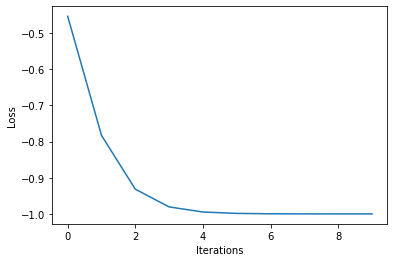

In [6]:
plt.plot(loss_history)
plt.xlabel("Iterations")
plt.ylabel("Loss")

We can also use QuTiP's excellent visualization tools to plot the rotation of
the Bloch vector at each step.

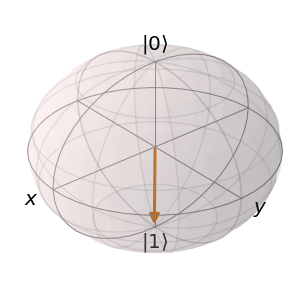

In [7]:
# Visualization

plt.rcParams["animation.html"] = "jshtml"
fig = plt.figure()
ax = Axes3D(fig, azim=-40, elev=30)
sphere = qutip.Bloch(axes=ax, fig=fig)

def animate(i):
    sphere.clear()
    sphere.add_states(state_hist[i])
    sphere.make_sphere()
    return ax

def init():
    sphere.vector_color = ["b"]
    return ax

ani = animation.FuncAnimation(
    fig,
    animate,
    np.arange(len(state_hist)),
    init_func=init,
    repeat=True
)
ani